In [1]:
%pylab inline
from jax.scipy.ndimage import map_coordinates
from constant import * 
import warnings
from jax import jit, partial, random, vmap
from tqdm import tqdm
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
nX = Xs.shape[0]
nA = As.shape[0]
Xs.shape, As.shape
Vgrid = np.load("Value.npy")

In [3]:
#Define the earning function, which applies for both employment status and 8 econ states
@partial(jit, static_argnums=(0,))
def y(t, x):
    '''
        x = [w,n,m,s,e,o]
        x = [0,1,2,3,4,5]
    '''
    if t <= T_R:
        return detEarning[t] * (1+gGDP[jnp.array(x[3], dtype = jnp.int8)]) * x[4] + (1-x[4]) * welfare
    else:
        return detEarning[-1]
    
#Earning after tax and fixed by transaction in and out from 401k account 
@partial(jit, static_argnums=(0,))
def yAT(t,x):
    yt = y(t, x)
    if t <= T_R:
        # yi portion of the income will be put into the 401k if employed
        return (1-tau_L)*(yt * (1-yi))*x[4] + (1-x[4])*yt
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + x[1]*Dn[t]
    
#Define the evolution of the amount in 401k account 
@partial(jit, static_argnums=(0,))
def gn(t, x, r = r_bar):
    if t <= T_R:
        # if the person is employed, then yi portion of his income goes into 401k 
        n_cur = x[1] + y(t, x) * yi * x[4]
    else:
        # t > T_R, n*Dn amount will be withdraw from the 401k 
        n_cur = x[1] - x[1]*Dn[t]
        # the 401 grow with the rate r 
    return (1+r)*n_cur

#Define the utility function
@jit
def u(c):
    return (jnp.power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of bequeath wealth
@jit
def uB(tb):
    return B*u(tb)

#Reward function depends on the housing and non-housing consumption
@jit
def R(x,a):
    '''
    Input:
        x = [w,n,m,s,e,o]
        x = [0,1,2,3,4,5]
        a = [c,b,k,h,action]
        a = [0,1,2,3,4]
    '''
    c = a[:,0]
    h = a[:,3]
    C = jnp.power(c, alpha) * jnp.power(h, 1-alpha)
    return u(C)

@partial(jit, static_argnums=(0,))
def feasibleActions(t, x):
    # owner
    sell = As[:,2]
    budget1 = yAT(t,x) + x[0] - (1-sell)*(x[2]*(1+rh)-x[2]*Dm[t]) + sell*(H*pt - x[2] - c_s) + (1-sell)*(((t<=T_R)*tau_L + (t>T_R)*tau_R)*x[2]*rh)
    # last term is the tax deduction of the interest portion of mortgage payment    
    h = jnp.ones(nA)*H*(1+kappa)*(1-sell) + sell*jnp.clip(budget1*As[:,0]*(1-alpha)/pr, a_max = 500)
    c = budget1*As[:,0]*(1-sell) + sell*(budget1*As[:,0] - h*pr)
    budget2 = budget1*(1-As[:,0])
    k = budget2*As[:,1]*(1-Kc)
    b = budget2*(1-As[:,1])
    owner_action = jnp.column_stack((c,b,k,h,sell))   
    # renter
    buy = As[:,2]
    budget1 = yAT(t,x) + x[0] - buy*(H*pt*0.2 + c_h)
    h = jnp.clip(budget1*As[:,0]*(1-alpha)/pr, a_max = 500)*(1-buy) + buy*jnp.ones(nA)*H*(1+kappa)
    c = (budget1*As[:,0] - h*pr)*(1-buy) + buy*budget1*As[:,0]
    budget2 = budget1*(1-As[:,0])
    k = budget2*As[:,1]*(1-Kc)
    b = budget2*(1-As[:,1])
    renter_action = jnp.column_stack((c,b,k,h,buy))
    
    actions = x[5]*owner_action + (1-x[5])*renter_action
    return actions

@partial(jit, static_argnums=(0,))
def transition(t,a,x):
    '''
        Input:
            x = [w,n,m,s,e,o]
            x = [0,1,2,3,4,5]
            a = [c,b,k,h,action]
            a = [0,1,2,3,4]
        Output:
            w_next
            n_next
            m_next
            s_next
            e_next
            o_next
            
            prob_next
    '''
    nA = a.shape[0]
    s = jnp.array(x[3], dtype = jnp.int8)
    e = jnp.array(x[4], dtype = jnp.int8)
    # actions taken
    b = a[:,1]
    k = a[:,2]
    action = a[:,4]
    w_next = ((1+r_b[s])*b + jnp.outer(k,(1+r_k)).T).T.flatten().repeat(nE)
    n_next = gn(t, x)*jnp.ones(w_next.size)
    s_next = jnp.tile(jnp.arange(nS),nA).repeat(nE)
    e_next = jnp.column_stack((e.repeat(nA*nS),(1-e).repeat(nA*nS))).flatten()
    # job status changing probability and econ state transition probability
    pe = Pe[s, e]
    ps = jnp.tile(Ps[s], nA)
    prob_next = jnp.column_stack(((1-pe)*ps,pe*ps)).flatten()
    
    # owner
    m_next_own = ((1-action)*x[2]*Dm[t]).repeat(nS*nE)
    o_next_own = (x[5] - action).repeat(nS*nE)
    # renter
    m_next_rent = (action*H*pt*0.8*Dm[t]).repeat(nS*nE)
    o_next_rent = action.repeat(nS*nE)
    
    m_next = x[5] * m_next_own + (1-x[5]) * m_next_rent
    o_next = x[5] * o_next_own + (1-x[5]) * o_next_rent   
    return jnp.column_stack((w_next,n_next,m_next,s_next,e_next,o_next,prob_next))

# used to calculate dot product
@jit
def dotProduct(p_next, uBTB):
    return (p_next*uBTB).reshape((p_next.shape[0]//(nS*nE), (nS*nE))).sum(axis = 1)

# define approximation of fit
@jit
def fit(v, xp):
    return map_coordinates(v,jnp.vstack((xp[:,0]/scaleW,
                                                      xp[:,1]/scaleN,
                                                      xp[:,2]/scaleM,
                                                      xp[:,3],
                                                      xp[:,4],
                                                      xp[:,5])),
                                                     order = 1, mode = 'nearest')

@partial(jit, static_argnums=(0,))
def V(t,V_next,x):
    '''
    x = [w,n,m,s,e,o]
    x = [0,1,2,3,4,5]
    xp:
        w_next    0
        n_next    1
        m_next    2
        s_next    3
        e_next    4
        o_next    5
        prob_next 6
    '''
    actions = feasibleActions(t,x)
    xp = transition(t,actions,x)
    # bequeath utility
    TB = xp[:,0]+x[1]*(1+r_bar)+xp[:,5]*(H*pt-x[2]*(1+rh)-c_s)
    bequeathU = uB(TB)
    if t == T_max-1:
        Q = R(x,actions) + beta * dotProduct(xp[:,6], bequeathU)
    else:
        Q = R(x,actions) + beta * dotProduct(xp[:,6], Pa[t]*fit(V_next, xp) + (1-Pa[t])*bequeathU)
    Q = jnp.nan_to_num(Q, nan = -100)
    v = Q.max()
    cbkha = actions[Q.argmax()]
    return v, cbkha.reshape((1,-1))

Probability of transition between employment and unemployment states is know: $P(0, 1 | S)$, $P(1, 0 | S)$, $P(1, 1 | S)$, $P(0, 0 | S)$   
   
   
The unconditional probability is:    
$$P(0,1) = \Sigma_{s = 1}^{s = 8}P(0, 1 | S = s)P(S=s)$$

In [4]:
S_distribution = jnp.ones(nS)/nS
for i in range(100):
    S_distribution = jnp.matmul(S_distribution, Ps)
S_distribution

DeviceArray([0.08723426, 0.12654275, 0.11381963, 0.17240335, 0.17240335,
             0.11381961, 0.12654276, 0.08723425], dtype=float32)

In [5]:
#P(0,1)
P01 = jnp.dot(Pe[:,0],S_distribution)
#P(1,0)
P10 = jnp.dot(Pe[:,1],S_distribution)
jnp.array([[1-P01, P01],[P10, 1-P10]])

DeviceArray([[0.23330271, 0.7666973 ],
             [0.06959809, 0.9304019 ]], dtype=float32)

In [7]:
E_distribution = jnp.ones(2)/2
for i in range(100):
    E_distribution = jnp.matmul(E_distribution, jnp.array([[1-P01, P01],[P10, 1-P10]]))
E_distribution

DeviceArray([0.08322192, 0.91677827], dtype=float32)

In [8]:
# Simulate 1000 economies
from quantecon import MarkovChain
mc = MarkovChain(Ps)

In [9]:
econ = mc.simulate(ts_length=T_max-T_min)

In [20]:
'''
    x = [w,n,m,s,e,o]
    x = [5,0,0,0,0,0]
'''
from jax import random

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, econ[0], initE, 0]
    path = []
    move = []
    for t in range(T_min, T_max-1):
        _, key = random.split(key)
        _,a = V(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition(t,a,x)
        valid = (xp[:,3]==econ[t+1])
        p = xp[:,-1]
        p = p*valid
        p = p/jnp.sum(p)
        x_next = xp[:,:-1]
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
        path.append(x)
        move.append(a[0])
    return jnp.array(path), jnp.array(move)

In [21]:
%%time
num = 1000
numEcon = 100
Paths = jnp.zeros((num*numEcon,59,6))
Moves = jnp.zeros((num*numEcon,59,6))
for i in range(numEcon):
    econ = mc.simulate(ts_length=T_max-T_min)
    # simulation part 
    keys = vmap(random.PRNGKey)(jnp.arange(num))
    Paths[i*num:(i+1)*num,:,:], Moves[i*num:(i+1)*num,:,:] = vmap(simulation)(keys)

CPU times: user 4h 24min 58s, sys: 24min 58s, total: 4h 49min 56s
Wall time: 13min 14s


In [22]:
# x = [w,n,m,s,e,o]
# x = [0,1,2,3,4,5]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T

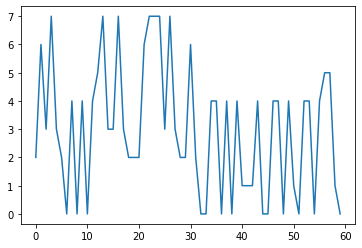

In [28]:
plt.plot(econ)

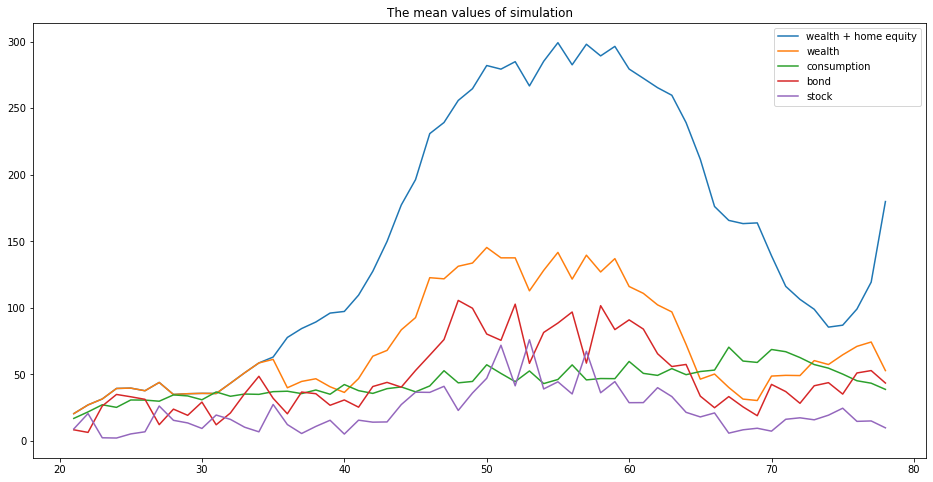

In [34]:
plt.figure(figsize = [16,8])
plt.title("The mean values of simulation")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ws + H*pt*os - ms,axis = 1)[:-1], label = "wealth + home equity")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ws,axis = 1)[:-1], label = "wealth")
plt.plot(range(21, T_max-1 + 20),jnp.mean(cs,axis = 1)[:-1], label = "consumption")
plt.plot(range(21, T_max-1 + 20),jnp.mean(bs,axis = 1)[:-1], label = "bond")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ks,axis = 1)[:-1], label = "stock")
# plt.plot((hs*pr).mean(axis = 1)[:-1], label = "housing")
plt.legend()

In [30]:
ws.shape

(59, 10000)

In [33]:
(hs).mean(axis = 1)[:-1]

DeviceArray([ 181.619  ,  233.8811 ,  291.4454 ,  270.4716 ,  329.8698 ,
              329.0522 ,  319.9341 ,  370.84604,  362.5429 ,  331.6244 ,
              394.5126 ,  359.77454,  377.76486,  375.22742,  403.85486,
              733.68286,  750.2501 ,  767.5451 ,  858.6842 ,  894.4598 ,
              896.6431 ,  890.8046 , 1022.1473 , 1103.7666 , 1159.6509 ,
             1164.6445 , 1208.545  , 1230.8505 , 1242.766  , 1247.4604 ,
             1245.2339 , 1246.5853 , 1252.2834 , 1238.6525 , 1216.6989 ,
             1207.2037 , 1169.374  , 1164.1823 , 1127.9163 , 1123.2062 ,
             1095.0583 , 1074.7667 , 1047.3804 , 1041.5938 , 1010.3902 ,
              873.0652 ,  880.2545 ,  894.7611 ,  875.7403 ,  749.6804 ,
              681.89795,  639.9361 ,  579.09814,  539.6858 ,  509.25864,
              553.2421 ,  607.6752 ,  917.0347 ], dtype=float32)

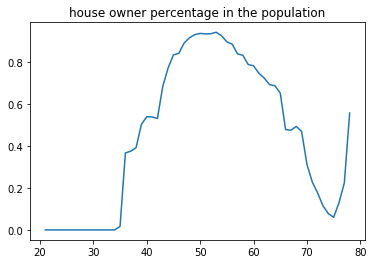

In [25]:
plt.title("house owner percentage in the population")
plt.plot(range(21, T_max-1 + 20),(os).mean(axis = 1)[:-1], label = "owning")

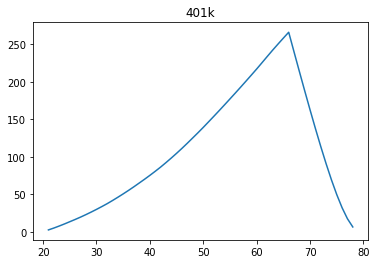

In [26]:
plt.title("401k")
plt.plot(range(21, T_max-1 + 20),(ns).mean(axis = 1)[:-1], label = "housing")

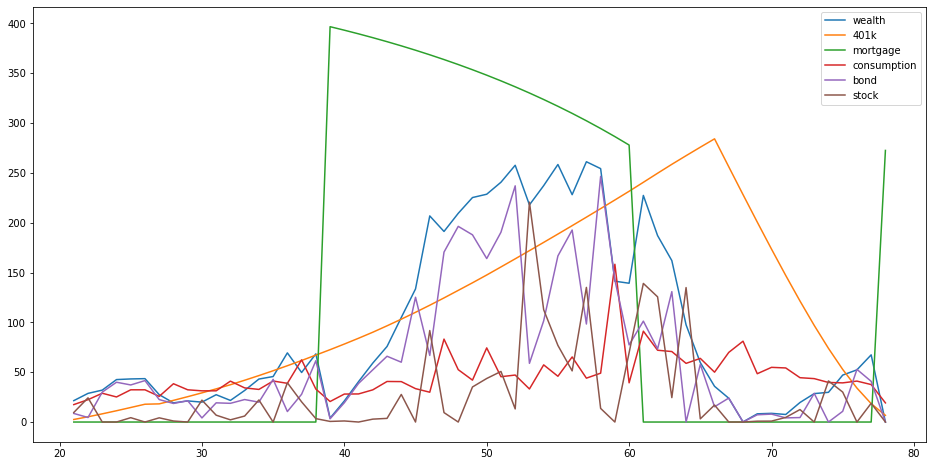

In [29]:
# agent number, x = [w,n,m,s,e,o]
agentNum = 134
plt.figure(figsize = [16,8])
plt.plot(range(21, T_max-1 + 20),ws[:,agentNum][:-1], label = "wealth")
plt.plot(range(21, T_max-1 + 20),ns[:,agentNum][:-1], label = "401k")
plt.plot(range(21, T_max-1 + 20),ms[:,agentNum][:-1], label = "mortgage")
plt.plot(range(21, T_max-1 + 20),cs[:,agentNum][:-1], label = "consumption")
plt.plot(range(21, T_max-1 + 20),bs[:,agentNum][:-1], label = "bond")
plt.plot(range(21, T_max-1 + 20),ks[:,agentNum][:-1], label = "stock")
plt.legend()